# Eigensolver using RDD's

In [1]:
# Import necessary modules
from neo4j import GraphDatabase
from graphframes import GraphFrame
from pyspark.sql import SparkSession
from py4j.java_gateway import JavaGateway
import numpy as np
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, Matrices, VectorUDT
from pyspark.sql import Column
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, StructType, StructField, DoubleType, ArrayType, StringType
import pyspark.sql.functions as F
import time

# Set the URI, username, and password for the Neo4j database
uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'

# Create a SparkSession to interface with the Neo4j database
spark = SparkSession.builder.appName('eigs_solver') \
    .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.0.0_for_spark_3,graphframes:graphframes:0.8.0-spark3.0-s_2.12') \
    .config('spark.neo4j.bolt.url', uri) \
    .config('spark.neo4j.bolt.user', user) \
    .config('spark.neo4j.bolt.password', password) \
    .getOrCreate()

# Query for the vertices that match the filter
vertices = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option('query','''MATCH (n)
                        RETURN id(n) as id''') \
    .load()

# Extract the vertex IDs from the DataFrame
vertex_ids = vertices.select("id").rdd.flatMap(lambda x: x).collect()

# Query for the edges that connect the specified vertices
edges = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", """MATCH (n1) --(n2)
                        WITH id(n1) as src, id(n2) as dst
                        RETURN src, dst""") \
    .load()

# # for Offshore DBMS
# # Query for the vertices that match the filter
# vertices = spark.read.format("org.neo4j.spark.DataSource") \
#     .option("url", uri) \
#     .option("authentication.basic.username", user) \
#     .option("authentication.basic.password", password) \
#     .option('query','''MATCH (n:OFFICER)--(o)
#                         WHERE n.countries = "United States"
#                         WITH COLLECT(DISTINCT id(n)) + COLLECT(DISTINCT id(o)) as vertex_ids
#                         MATCH (n)
#                         WHERE id(n) in vertex_ids
#                         WITH n.name as name, id(n) as id
#                         RETURN name, id''') \
#     .load()

# # Query for the edges that connect the specified vertices
# edges = spark.read.format("org.neo4j.spark.DataSource") \
#     .option("url", uri) \
#     .option("authentication.basic.username", user) \
#     .option("authentication.basic.password", password) \
#     .option("query", """MATCH (n:OFFICER)--(o)
#                         WHERE n.countries = "United States"
#                         WITH COLLECT(DISTINCT id(n)) + COLLECT( DISTINCT id(o)) as vertex_ids
#                         MATCH (n1)--(n2)
#                         WHERE id(n1) IN vertex_ids AND id(n2) in vertex_ids
#                         WITH id(n1) as src, id(n2) as dst
#                         RETURN src, dst""") \
#     .load()


# Create a GraphFrame object using the vertices and edges DataFrame
graph = GraphFrame(vertices, edges)

:: loading settings :: url = jar:file:/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/michaelroth/.ivy2/cache
The jars for the packages stored in: /Users/michaelroth/.ivy2/jars
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-97fedea0-4012-4875-804e-9311d8809367;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.0.0_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.0.0 in central
	found org.neo4j.driver#neo4j-java-driver;4.4.9 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found org.apache.xbean#xbean-asm6-shaded;4.10 in central
	found org.neo4j#neo4j-cypher-dsl;2020.1.4 in central
	found org.apiguardian#apiguardian-api;1.1.0 in central
	found graphframes#graphframes;0.8.0-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 640ms :: artifacts dl 41ms
	:: modules in use:
	

23/03/24 18:11:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/24 18:11:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


# Create Laplacian Matrix

In [2]:
# Create a variable edge_data that contains the graph.edges data
edge_data = graph.edges

# Construct the adjacency matrix as a DataFrame
adjacency_matrix = edge_data.selectExpr("src as i", "dst as j", "1 as value") \
                            .distinct().sort('i', 'j')

# Construct the degree matrix as a DataFrame
degree_matrix = adjacency_matrix.groupby('i') \
                                .sum('value') \
                                .withColumn('j', col('i')) \
                                .select('i', 'j', 'sum(value)') \
                                .withColumnRenamed('sum(value)', 'value') \
                                .sort('i')

# Get n number of total nodes in the complete graph
n = degree_matrix.selectExpr('MAX(i) AS n').first().n

In [3]:
# Compute the Laplacian matrix as a RDD
laplacian_matrix = degree_matrix.union(adjacency_matrix) \
            .withColumn("laplacian", col("value") * (F.when(col('i') == col('j'), 1).otherwise(-1))) \
            .select('i', 'j', 'laplacian')


# Lanczos method with RDD's

In [4]:
# Function for dot product between matrix (j, (i, value)) and vector (i, value)
def matrix_vector_dot_product(matrix_rdd, vector_rdd, num_partitions):
    dot_product_rdd = matrix_rdd.join(vector_rdd) \
                                .map(lambda x: (x[1][0][0], x[1][0][1] * x[1][1])) \
                                .reduceByKey(lambda x, y: x + y).repartition(num_partitions)
    return dot_product_rdd

# Function for dot product between vector and vector (i, value)
def vector_vector_dot_product(vector1_rdd, vector2_rdd):
    dot_product_rdd = vector1_rdd.join(vector2_rdd) \
                                .mapValues(lambda x: x[0]*x[1]) \
                                .map(lambda x: (0, x[1])) \
                                .reduceByKey(lambda x, y: x+y).repartition(num_partitions)
    return dot_product_rdd
    
# Function to return the Euclidean norm of a vector
def get_vector_norm(vector_rdd):
    return vector_rdd.map(lambda x: x[1]*x[1]).reduce(lambda x, y: x+y)**.5

# Function to normalize a vector based on its Euclidean norm
def normalize_vector(vector_rdd):
    norm = get_vector_norm(vector_rdd)
    return vector_rdd.mapValues(lambda x: x / norm)

# Lanczos Method implementation
def lanczos(matrix_rdd, v_i_rdd, num_partitions, m=10):
    alpha, beta = [], []

    for i in range(m):
        start = time.time()
        w_i_rdd = matrix_vector_dot_product(matrix_rdd, v_i_rdd, num_partitions)
        alpha_i = vector_vector_dot_product(v_i_rdd, w_i_rdd).reduce(lambda x, y: x+y)[1]
        
        w_i_rdd = w_i_rdd.join(v_i_rdd).mapValues(lambda x: x[0] - (x[1] * alpha_i)).repartition(num_partitions)

        if i > 0:
            w_i_rdd = w_i_rdd.join(v_im1_rdd).mapValues(lambda x: x[0] - (x[1] * beta_i)).repartition(num_partitions)
            
        beta_i = get_vector_norm(w_i_rdd)
        if beta_i == 0:
            break

        alpha.append(alpha_i)
        beta.append(beta_i)
        
        v_im1_rdd = v_i_rdd
        v_i_rdd = w_i_rdd.mapValues(lambda x: x / beta_i)
        print(i, f'{time.time() - start:.2f}', end='\r')

    return alpha, beta[:-1]

num_partitions = 10

laplacian_rdd = laplacian_matrix.rdd.map(lambda row: (row.j, (row.i, row.laplacian))).repartition(num_partitions)
laplacian_rdd.cache()
%time print(laplacian_rdd.take(1))
sc = laplacian_rdd.context

q_rdd = sc.parallelize(np.random.rand(n)).zipWithIndex().map(lambda x: (x[1], x[0])).repartition(num_partitions)
v_i_rdd = normalize_vector(q_rdd)
%time print(v_i_rdd.take(1))

[(90, (90, 1))]
CPU times: user 3.91 ms, sys: 1.52 ms, total: 5.43 ms
Wall time: 1.9 s
[(120, 0.11081409139787442)]
CPU times: user 1.84 ms, sys: 733 µs, total: 2.57 ms
Wall time: 123 ms


In [5]:
# m number of Lanczos iterations will also return m eigenvalues and eigenvectors
m = 10

# %time alpha, beta = lanczos(laplacian_rdd, v_i_rdd, num_partitions, m=m)

# print(alpha)
# print(beta)

In [6]:
# from scipy.linalg import eigh_tridiagonal

# eig_vals, eig_vecs = eigh_tridiagonal(alpha, beta)
# eig_vals

In [7]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.title('Eigenvalues of Lanczos method implementation')
# plt.plot(eig_vals)

# Lanczos method with Implicit Restarts

In [8]:
from scipy.linalg import eigh_tridiagonal

# Lanczos method with implicit restarts
# The implicit restarts will restart the method using the Ritz vector as the starting vector
# This implementation will return the m smallest eigenvalues and their respective eigenvectors

def implicit_restarts_lanczos(matrix_rdd, v_i_rdd, m=2, num_restarts=5, num_partitions=1):
    matrix_rdd.cache()
    for restart in range(num_restarts):
        print(f'Restart: {restart} \n')
        alpha, beta = lanczos(matrix_rdd, v_i_rdd, num_partitions, m)
        
        # Compute the eigenvectors and eigenvalues of the tridiagonal matrix T
        eigenvalues, eigenvectors = eigh_tridiagonal(alpha, beta)
        
        # Sort the eigenvalues and eigenvectors in ascending order
        sorted_indices = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        # Update the initial vector for the next iteration (Ritz vector)
        ritz_vector = eigenvectors[:, 0]  # The eigenvector corresponding to the smallest eigenvalue
        v_i_rdd = v_i_rdd.join(sc.parallelize(enumerate(ritz_vector))) \
                         .mapValues(lambda x: x[0] * x[1]) \
                         .reduceByKey(lambda x, y: x + y).repartition(num_partitions)
        v_i_rdd.cache()
        
    matrix_rdd.unpersist()
    v_i_rdd.unpersist()
    
    return eigenvalues, eigenvectors

In [9]:
m = 10
num_restarts = 10

# %time eigenvalues, eigenvectors = implicit_restarts_lanczos(laplacian_rdd, v_i_rdd, m=m, num_restarts=num_restarts, num_partitions=num_partitions)

In [10]:
# eigenvalues

In [11]:
# plt.figure()
# plt.title('Eigenvalues of Lanczos method implementation with implicit restarts')
# plt.plot(eigenvalues)

# Householder Method

In [12]:
# numpy version
# def householder(matrix, k):
#     x = matrix[k:, k].copy()
#     x[0] -= np.sign(x[0]) * np.linalg.norm(x)
#     v = x / np.linalg.norm(x)
    
#     H = np.eye(matrix.shape[0])
#     H[k:, k:] -= 2 * np.outer(v, v)
    
#     matrix = H @ matrix @ H
#     return matrix

# def symmetric_to_tridiagonal(matrix):
#     n = matrix.shape[0]
#     for k in range(n - 2):
#         matrix = householder(matrix, k)
#     return matrix

# # Example
# A = np.array([[4, 1, 1],
#               [1, 4, 1],
#               [1, 1, 4]], dtype=float)

# T = symmetric_to_tridiagonal(A)
# print(T)

In [13]:
laplacian_rdd_hh = laplacian_matrix.rdd.map(lambda row: (row.i, row.j, row.laplacian)).repartition(num_partitions)

In [14]:
laplacian_rdd_hh.take(1)

[(90, 90, 1)]

In [ ]:
# def householder_transformation(matrix_rdd, k, num_partitions):
#     # Get the column vector
#     col_vector = matrix_rdd.filter(lambda x: x[0] >= k and x[1] == k).map(lambda x: (x[0], x[2]))

#     # Calculate the Householder vector v
#     x = col_vector.collect()
#     if len(x) == 0:
#         return matrix_rdd
#     x[0] = (x[0][0], x[0][1] - sum(xi[1]**2 for xi in x[1:])**0.5)
#     v = col_vector.context.parallelize(x)

#     # Calculate the Householder matrix H as outer product of v and v
#     norm_v = v.map(lambda x: x[1]**2).reduce(lambda x, y: x + y)
#     H_rdd = outer_product(v, v).map(lambda x: (x[0][0],(x[0][1], x[1] * (-2 / norm_v))))

#     # Apply the Householder transformation to the matrix A
#     A_new = matrix_rdd.map(lambda x: (x[0], (x[1], x[2]))).join(H_rdd) \
#                         .map(lambda x: (x[1][0][0], (x[0], x[1][0][1] * x[1][1][1]))) \
#                         .join(H_rdd).map(lambda x: (x[0], x[1][0][0], x[1][0][1] * x[1][1][1]))
#     cols = A_new.map(lambda x: (x[0], x[1]))
    
#     A_new = A_new.map(lambda x: (x[0], x[2])).reduceByKey(lambda x, y: x + y).join(cols).reduceByKey(lambda x,y: x).map(lambda x: (x[0], x[1][1], x[1][0])).repartition(num_partitions)
                      
#     return A_new


In [83]:
def outer_product(vector1_rdd, vector2_rdd):
    return vector1_rdd.cartesian(vector2_rdd).map(lambda x: ((x[0][0], x[1][0]), x[0][1] * x[1][1]))

def householder_transformation(matrix_rdd, k, num_partitions):
    # Get the column vector
    col_vector = matrix_rdd.filter(lambda x: x[0] >= k and x[1] == k).map(lambda x: (x[0], x[2]))

    # Calculate the Householder vector v
    x = col_vector.collect()
    if len(x) == 0:
        return matrix_rdd
    x[0] = (x[0][0], x[0][1] - sum(xi[1] ** 2 for xi in x[1:]) ** 0.5)
    v = col_vector.context.parallelize(x)

    # Calculate the Householder matrix H as the outer product of v and v
    norm_v = v.map(lambda x: x[1] ** 2).reduce(lambda x, y: x + y)
    H_rdd = outer_product(v, v).map(lambda x: (x[0][0], (x[0][1], x[1] * (-2 / norm_v))))

    # Apply the Householder transformation to the matrix A
    A_new = matrix_rdd.map(lambda x: (x[0], (x[1], x[2]))) \
                        .join(H_rdd) \
                        .map(lambda x: (x[1][0][0], (x[0], x[1][0][1] * x[1][1][1]))) \
                        .join(H_rdd) \
                        .map(lambda x: (x[0], x[1][0][0], x[1][0][1] * x[1][1][1]))

    cols = A_new.map(lambda x: (x[0], x[1]))

    A_new = A_new.map(lambda x: (x[0], x[2])) \
                  .reduceByKey(lambda x, y: x + y) \
                  .join(cols) \
                  .reduceByKey(lambda x, y: x) \
                  .map(lambda x: (x[0], x[1][1], x[1][0])) \
                  .repartition(num_partitions)

    return A_new


In [90]:
householder_transformation(laplacian_rdd_hh, 1, num_partitions).collect()

[(100, 1, 0.11252835662174324),
 (9, 1, 0.13609324553157098),
 (1, 1, 2.029562191176951),
 (10, 1, 0.13609324553157098),
 (11, 1, 0.10074591216682931),
 (87, 1, 0.14787568998648487),
 (152, 1, 0.10074591216682931)]

In [85]:
k = 0

def symmetric_to_tridiagonal(matrix_rdd, num_partitions):
    n = matrix_rdd.filter(lambda x: x[0]).reduce(lambda a,b: max(a,b))[0]
    for k in range(n - 2):
        start = time.time()
        matrix_rdd = householder_transformation(matrix_rdd, k, num_partitions)
        print(k, time.time() - start, end='\r')
    matrix_rdd.map(lambda x: (x[0], x[1], x[2]))
    return matrix_rdd

tridiagonal_matrix_rdd = symmetric_to_tridiagonal(laplacian_rdd_hh, num_partitions)

In [86]:
tridiagonal_matrix_rdd.collect()

[(6, 0, 0.3226323415204601),
 (0, 0, 6.768145615274377),
 (2, 0, 0.21660419057329416),
 (3, 0, 0.21660419057329416),
 (7, 0, 0.2961253037836687),
 (1, 0, 0.3226323415204601),
 (4, 0, 0.2696182660468773),
 (8, 0, 0.16359011509971186),
 (5, 0, 0.3226323415204601)]

## Need to fix pyspark implementation to follow as below.

In [96]:
import numpy as np

def householder(matrix, k):
    x = matrix[k:, k].copy()
    x[0] -= np.sign(x[0]) * np.linalg.norm(x)
    if sum(x) == 0:
        return matrix
    v = x / np.linalg.norm(x)
    
    H = np.eye(matrix.shape[0])
    H[k:, k:] -= 2 * np.outer(v, v)
    
    matrix = H @ matrix @ H
    return matrix

def symmetric_to_tridiagonal(matrix):
    n = matrix.shape[0]
    for k in range(n - 2):
        matrix = householder(matrix, k)
    return matrix

# Example
laplacian_values = laplacian_rdd_hh.collect()
laplacian_np = np.zeros((n+1,n+1))
for i, j, value in laplacian_values:
    laplacian_np[i, j] = value

T = symmetric_to_tridiagonal(laplacian_np)
print(T)



[[ 9.43055556e+00  2.94537987e-01  1.44679304e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.94537987e-01  8.35394674e+00  1.29427439e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.44679304e+00  1.29427439e+00  8.05944331e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
  -7.84028007e-17  8.11151824e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.53246652e-17
   5.00000000e-01 -5.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.75690896e-17
  -5.00000000e-01  5.00000000e-01]]


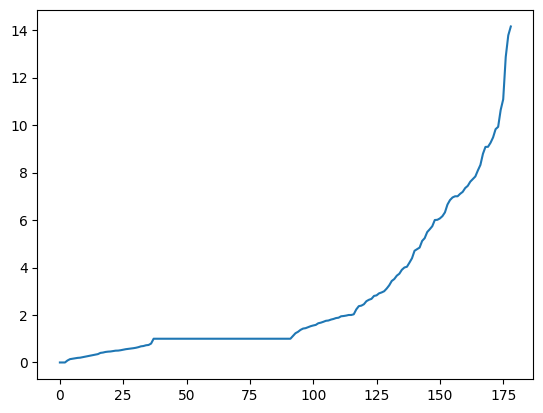

In [100]:
from scipy.linalg import eigh
import matplotlib.pyplot as plt

evals, evecs = eigh(T)
plt.plot(evals)